<a href="https://colab.research.google.com/github/ayush111111/unet-fet/blob/main/Copy_of_Unet_fetal_head_seg_new_runall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Imports and augmentation


In [2]:
%cd drive/MyDrive/'Semester Project '/dataset_filled/
%ls


/content/drive/MyDrive/Semester Project /dataset_filled
 best_model_224_res_64epoch_1e-4_val_coef_98.h5
 best_model_224_res_reduce_lr.h5
 best_model_224_res_retraining_1e-4.h5
 best_model_224_res_unk.h5
 best_model_224_res_VUNET.h5
'Copy of best_model_224_res_64epoch_1e-4_val_coef_98.h5'
'Copy of best_model_224_res.h5'
 model.png
 test_set/
 training_set/


In [3]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [4]:


trainPath = "training_set/"
testPath = "test_set/"
trainList = sorted(os.listdir(trainPath))
testList = sorted(os.listdir(testPath))


train_image = []
train_mask = []
for i, item in enumerate(trainList):
    if i % 2 == 0:
        train_image.append(item)
    else:
        train_mask.append(item)
print("Ultrasound training images in dataset {}".format(len(train_image)))
print("Ultrasound training masks in dataset  {}".format(len(train_mask)))  

Ultrasound training images in dataset 999
Ultrasound training masks in dataset  999


800


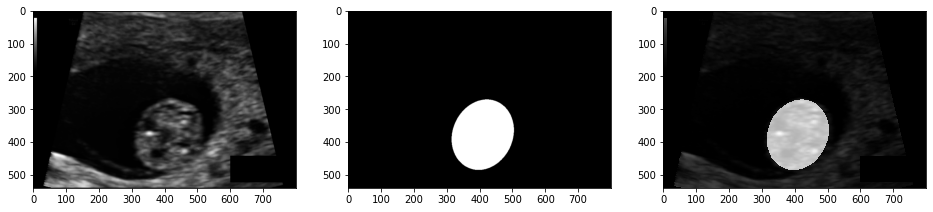

In [5]:

img = np.array(Image.open(trainPath+"000_HC.png"))
img_mask = np.array(Image.open(trainPath+"000_HC_Annotation.png"))
img_mask = np.ma.masked_where(img_mask == 0, img_mask)
print(len(img[0]))
#display images with mask
fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(img_mask, cmap = 'gray')
ax[2].imshow(img, cmap = 'gray', interpolation = 'none')
ax[2].imshow(img_mask, cmap = 'gray', interpolation = 'none', alpha = 0.7)


In [6]:

#
X = []
y = []
for image, mask in zip(train_image, train_mask):
    X.append(np.array(Image.open(trainPath+image)))
    y.append(np.array(Image.open(trainPath+mask)))

X = np.array(X)
y = np.array(y)

print("X_shape : ", X.shape)
print("y_shape : ", y.shape)



X_shape :  (999,)
y_shape :  (999,)


<ipython-input-6-5829c98f866b>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
<ipython-input-6-5829c98f866b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


In [7]:
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


IMG_HEIGHT = 224
IMG_WIDTH = 224

In [8]:
def Generator(X_list, y_list, batch_size = 16):
    c = 0

    while(True):
        X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            image = X_list[i]
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            mask =  y_list[i]
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            X[i - c] = image
            y[i - c] = mask
        
        X = X[:,:,:,np.newaxis] / 255
        y = y[:,:,:,np.newaxis] / 255
        
        c += batch_size
        if(c+batch_size >= len(X_list)):
            c = 0
        yield X, y

In [9]:
train_img_aug = []
train_mask_aug = []


for img, mask in zip(train_image, train_mask):
    img = cv2.imread(trainPath + img)
    mask = cv2.imread(trainPath + mask)
    train_img_aug.append(img)
    
    train_mask_aug.append(mask)
    img_lr = np.fliplr(img)
    mask_lr = np.fliplr(mask)

    img_up = np.flipud(img)
    mask_up = np.flipud(mask)

    img_lr_up = np.flipud(img_lr)
    mask_lr_up = np.flipud(mask_lr)

    img_up_lr = np.fliplr(img_up)
    mask_up_lr = np.fliplr(mask_up)

    train_img_aug.append(img_lr)
    train_mask_aug.append(mask_lr)

    train_img_aug.append(img_up)
    train_mask_aug.append(mask_up)

    train_img_aug.append(img_lr_up)
    train_mask_aug.append(mask_lr_up)

    train_img_aug.append(img_up_lr)
    train_mask_aug.append(mask_up_lr)

print(len(train_image))
print(len(train_img_aug))

999
4995


# Model Training

In [10]:
smooth=1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [11]:
# define building blocks
def BatchnormActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_block(x, filters, size, strides=(1,1), padding="same", activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchnormActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchnormActivate(blockInput)
    x = conv_block(x, num_filters, (3,3))
    x = conv_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchnormActivate(x)
    return x

In [12]:

def build_Unet(input_layer, start_neurons, DropoutRatio = 0.5):
    

    """ Encoder """
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(DropoutRatio/2)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(DropoutRatio)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(DropoutRatio)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(DropoutRatio)(pool4)


    """ Bridge """
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)



    """ Decoder """
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    #uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    #uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    """ Output """
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [13]:


#split training data

#test_size changed from 0.3 t0 0.2 
X_train, X_val, y_train, y_val = train_test_split(train_img_aug, train_mask_aug, test_size = 0.2, random_state = 1)

# set training parameters
epochs = 100
batch_size = 16
steps_per_epoch = int(len(X_train) / batch_size)
validation_steps = int(len(X_val) / batch_size)

train_gen = Generator(X_train, y_train, batch_size = batch_size)
val_gen = Generator(X_val, y_val, batch_size = batch_size)

# initialize our model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
output_layer = build_Unet(inputs, 16, 0.5)

# Define callbacks to save model with best val_dice_coef
checkpointer = ModelCheckpoint(filepath = 'best_model_224_res_reduce_lr.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
model = Model(inputs=[inputs], outputs=[output_layer])
model.compile(optimizer=Adam(lr = 1e-4), loss=dice_coef_loss, metrics=['accuracy',dice_coef,specificity,sensitivity,precision,])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5)



# fit model

In [ ]:


# results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer,reduce_lr])



<ipython-input-15-97ab44bd4fe9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer,reduce_lr])


Epoch 1/100
249/249 [==============================] - ETA: 0s - loss: -0.6853 - accuracy: 0.8868 - dice_coef: 0.6853 - specificity: 0.8698 - sensitivity: 0.9431 - precision: 0.7899
Epoch 1: val_dice_coef improved from -inf to 0.64407, saving model to best_model_224_res_reduce_lr.h5
249/249 [==============================] - 107s 370ms/step - loss: -0.6853 - accuracy: 0.8868 - dice_coef: 0.6853 - specificity: 0.8698 - sensitivity: 0.9431 - precision: 0.7899 - val_loss: -0.6441 - val_accuracy: 0.8838 - val_dice_coef: 0.6441 - val_specificity: 0.9691 - val_sensitivity: 0.6950 - val_precision: 0.9050 - lr: 1.0000e-04
Epoch 2/100
249/249 [==============================] - ETA: 0s - loss: -0.7782 - accuracy: 0.9677 - dice_coef: 0.7782 - specificity: 0.9663 - sensitivity: 0.9870 - precision: 0.9226
Epoch 2: val_dice_coef improved from 0.64407 to 0.78333, saving model to best_model_224_res_reduce_lr.h5
249/249 [==============================] - 91s 366ms/step - loss: -0.7782 - accuracy: 0.967

# Visualize training


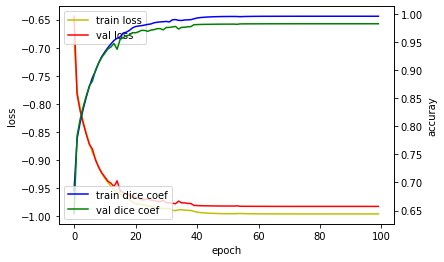

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

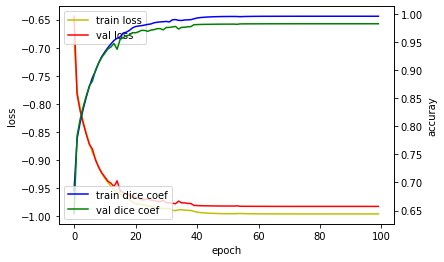

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

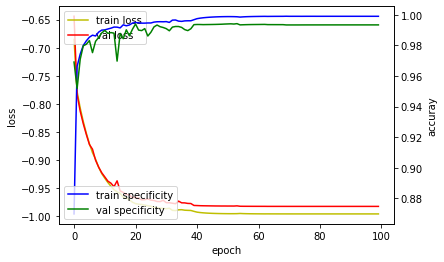

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['specificity'], 'b', label='train specificity')
acc_ax.plot(results.history['val_specificity'], 'g', label='val specificity')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

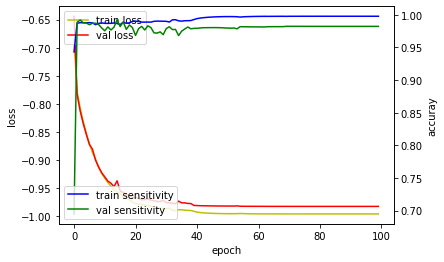

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['sensitivity'], 'b', label='train sensitivity')
acc_ax.plot(results.history['val_sensitivity'], 'g', label='val sensitivity')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

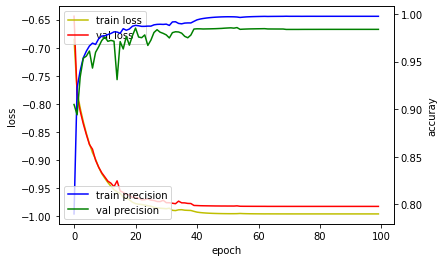

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['precision'], 'b', label='train precision')
acc_ax.plot(results.history['val_precision'], 'g', label='val precision')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
print(results.history['precision'][-1])

0.9976980090141296


In [ ]:
print(results.history['dice_coef'][-1])

0.995529294013977


In [ ]:
print(results.history['specificity'][-1])

NameError: ignored

# Predict



In [14]:

# import os
test_list = os.listdir("test_set/")
print("The number of test data : ", len(test_list))
test_list[:5]



The number of test data :  335


['001_HC.png', '000_HC.png', '003_HC.png', '004_HC.png', '002_HC.png']

In [15]:
#used just for prediction, not as a checkpoint
model = tf.keras.models.load_model('best_model_224_res_reduce_lr.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef,'specificity':specificity,'sensitivity':sensitivity,'precision':precision})

In [16]:
smooth=1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)




In [17]:
def dice_coef(y_true, y_pred):
    # convert to 2D before comparing results
    # y_true = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # print(np.array(y_true).shape)
    # print(np.array(y_pred).shape)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)


    # print((2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) ))
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jac_distance(y_true, y_pred ):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # intersection = K.sum(y_true_f * y_pred_f)

    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    sum_ = K.sum(K.abs(y_true_f) + K.abs(y_pred_f), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    # print(jac)
    return jac


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [18]:


def getbound(binary_mask):

  # draw = np.zeros((*img.shape, 3), dtype=np.uint8)

  # draw[img > 0.5] = (255,) * 3
  kernelSize = (3,3)

  # gray = cv2.cvtColor(draw, cv2.COLOR_BGR2GRAY)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
  gradient = cv2.morphologyEx(binary_mask, cv2.MORPH_GRADIENT, kernel)
  # plt.imshow()
  # plt.show()
  # gradient = cv2.cvtColor(gradient, cv2.COLOR_GRAY2RGB)
  return gradient


def fitEllipse(binary_mask, method):
    assert binary_mask.min() >= 0.0 and binary_mask.max() <= 1.0

    # print(binary_mask.shape)
   
    gradient  = getbound(binary_mask)

    # print(gradient.shape)

    points1 = np.argwhere(gradient > 0.5)  
    points2 = np.argwhere(binary_mask > 0.5)  

    points = points1
    # print(points1.shape)
    # print(points2.shape)

    if method == "AMS":
      #taubins method
        (xx, yy), (MA, ma), angle = cv2.fitEllipseAMS(points)
    elif method == "Direct":
      #Fitzgibbon1999
        (xx, yy), (MA, ma), angle = cv2.fitEllipseDirect(points)
    elif method == "Simple":
      #Fitzgibbon95]
        (xx, yy), (MA, ma), angle = cv2.fitEllipse(points)

    return (xx, yy), (MA, ma), angle


In [19]:
X_50 = train_image[:]
y_50  = train_mask[:]

X_test = np.empty((len(X_50[:]), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')


for i, item in enumerate(X_50[:]):
    image = cv2.imread("training_set/" + item, 0)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    X_test[i] = image


X_test = X_test[:,:,:,np.newaxis] / 255



In [20]:
X_test.shape

(999, 224, 224, 1)

In [21]:

y_pred = model.predict(X_test)



32/32 [==============================] - 15s 160ms/step


In [22]:
y_pred.shape

(999, 224, 224, 1)

In [90]:
i=0

dice_val = []
jac_val = []
# ellipse_val = []
precision_val = []
specificity_val = []
sensitivity_val  = []

ellipse_val_direct = []
ellipse_val_direct_img = []
ellipse_val_direct_dice = []

ellipse_val_AMS = []
ellipse_val_AMS_img = []
ellipse_val_AMS_dice = []

ellipse_val_Simple = []
ellipse_val_Simple_img = []
ellipse_val_Simple_dice = []




for test, pred in zip(X_test[:],y_pred[:]):

    y_true = cv2.imread("training_set/" + y_50[i], 0)
    # y_true = cv2.cvtColor(y_50[i], cv2.COLOR_BGR2GRAY)
    y_true = cv2.resize(y_true, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    y_true = np.array(y_true).astype(float) / 255.0
    y_p = np.array(pred).astype(float)


    dice = dice_coef( y_true, y_p)
    jac = jac_distance(y_true, y_p)
    pr = precision( y_true, y_p)
    sp = specificity( y_true, y_p)
    se = sensitivity( y_true, y_p)

    dice_val.append(dice)
    jac_val.append(jac)
    precision_val.append(pr)
    specificity_val.append(sp)
    sensitivity_val.append(se)
    i=i+1

    # fig, ax = plt.subplots(1,4,figsize = (16,16))
    # test = test.reshape((IMG_HEIGHT,IMG_WIDTH))
    # pred = pred.reshape((IMG_HEIGHT,IMG_WIDTH))

    #direct
    img1 = pred.copy()
    (xx1, yy1), (MA1, ma1), angle1 = fitEllipse(img1,method="Direct")
    # print((xx, yy), (MA, ma), angle)
    ellipse_val_direct.append([(xx1, yy1), (MA1, ma1), angle1])
    img1 = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
    
    cv2.ellipse(
        img1,
        (int(yy1), int(xx1)),
        (int(ma1 / 2), int(MA1 / 2)),
        -angle1,
        0,
        360,
        color=(255, 255, 255),
        thickness=-1,
    )
    
    ellipse_val_direct_img.append(img1)
    img1 =  cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    ed = dice_coef( y_true, np.array(img1).astype(float)/255.0)
    ellipse_val_direct_dice.append(ed)



    #AMS
    img2 = pred.copy()
    (xx2, yy2), (MA2, ma2), angle2 = fitEllipse(img2,method="AMS")
    # print((xx, yy), (MA, ma), angle)
    ellipse_val_AMS.append([(xx2, yy2), (MA2, ma2), angle2])
    img2 = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
    cv2.ellipse(
        img2,
        (int(yy2), int(xx2)),
        (int(ma2 / 2), int(MA2 / 2)),
        -angle2,
        0,
        360,
        color=(255, 255, 255),
        thickness=-1,
    )
    
    ellipse_val_AMS_img.append(img2)
    img2 =  cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    ed = dice_coef( y_true, np.array(img2).astype(float)/255.0)
    ellipse_val_AMS_dice.append(ed)

    #simple
    img3 = pred.copy()
    (xx3, yy3), (MA3, ma3), angle3 = fitEllipse(img3,method="Simple")
    # print((xx, yy), (MA, ma), angle)
    ellipse_val_Simple.append([(xx3, yy3), (MA3, ma3), angle3])
    img3 = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
    cv2.ellipse(
        img3,
        (int(yy3), int(xx3)),
        (int(ma3 / 2), int(MA3 / 2)),
        -angle3,
        0,
        360,
        color=(255, 255, 255),
        thickness=-1,
    )
    
    ellipse_val_Simple_img.append(img3)
    img3 =  cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
    ed = dice_coef( y_true, np.array(img3).astype(float)/255.0)
    ellipse_val_Simple_dice.append(ed)


    # draw = np.zeros((*img.shape, 3), dtype=np.uint8)
    # draw = draw + 255  
    # # draw[img > 0.5] = (255,) * 3


    # cv2.ellipse(
    #     draw,
    #     (int(yy1), int(xx1)),
    #     (int(ma1 / 2), int(MA1 / 2)),
    #     -angle1,
    #     0,
    #     360,
    #     color=(255, 0, 0),
    #     thickness=3,
    # )
    
    # cv2.ellipse(
    #     draw,
    #     (int(yy2), int(xx2)),
    #     (int(ma2 / 2), int(MA2/ 2)),
    #     -angle2,
    #     0,
    #     360,
    #     color=(0, 255, 0),
    #     thickness=2,
    # )
    
    # cv2.ellipse(
    #     draw,
    #     (int(yy3), int(xx3)),
    #     (int(ma3 / 2), int(MA3 / 2)),
    #     -angle3,
    #     0,
    #     360,
    #     color=(0, 0, 255),
    #     thickness=1,
    # )
    
    # pred = pred<0.5
    # pred = np.ma.masked_where(pred == 0, pred)

    # ax[0].imshow(test, cmap = 'gray')

    # ax[1].imshow(pred, cmap = 'gray', interpolation = 'none')
    # ax[1].imshow(y_true, cmap = 'jet', interpolation = 'none', alpha=0.7)

    # ax[2].imshow(test, cmap = 'gray', interpolation = 'none')
    # ax[2].imshow(pred, cmap = 'jet', interpolation = 'none', alpha = 0.7)
    # ax[3].text(3, 7, 'dice ' + str(round(float(dice),4)) + '\njacc ' + str(round(float(jac),4)), fontsize = 15, color = 'g')

    # ax[3].imshow(draw,cmap='jet')

# statistical analysis

In [91]:
import pandas as pd

In [148]:
#take input as index
def showImage(i,method):
  test = X_test[i]
  pred = y_pred[i]
  draw = np.zeros((*img.shape, 3), dtype=np.uint8)
  draw = draw + 255  
    # # draw[img > 0.5] = (255,) * 3
  y_true = cv2.imread("training_set/" + y_50[i], 0)
  # y_true = cv2.cvtColor(y_50[i], cv2.COLOR_BGR2GRAY)
  y_true = cv2.resize(y_true, (IMG_HEIGHT, IMG_WIDTH), interpolation=cv2.INTER_AREA)
  y_true = np.array(y_true).astype(float) / 255.0
  y_p = np.array(pred).astype(float)
  dice = dice_coef( y_true, y_p)
  jac = jac_distance(y_true, y_p)


  img3 = pred.copy()
  (xx3, yy3), (MA3, ma3), angle3 = fitEllipse(img3,method)
  img3 = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), np.uint8)
  cv2.ellipse(draw, (int(yy3), int(xx3)), (int(ma3 / 2), int(MA3 / 2)), -angle3, 0, 360,color=(255, 0, 0), thickness=-1)
  cv2.ellipse(img3, (int(yy3), int(xx3)), (int(ma3 / 2), int(MA3 / 2)), -angle3, 0, 360,color=(255, 255, 255), thickness=-1)
  img3 =  cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)
  ed = dice_coef( y_true, np.array(img3).astype(float)/255.0)
  ej = jac_distance( y_true, np.array(img3).astype(float)/255.0)

  fig, ax = plt.subplots(1, 4, figsize=(16, 16))
  test = test.reshape((IMG_HEIGHT, IMG_WIDTH))
  pred = pred.reshape((IMG_HEIGHT, IMG_WIDTH))
  ax[0].imshow(test, cmap='gray')

  ax[1].imshow(pred, cmap='gray', interpolation='none')
  ax[1].imshow(y_true, cmap='jet', interpolation='none', alpha=0.7)
  ax[1].text(3, 7, 'dice ' + str(round(float(dice), 4)) + '\njacc ' + str(round(float(jac), 4)), fontsize=15, color='g')

  ax[2].imshow(test, cmap='gray', interpolation='none')
  ax[2].imshow(pred, cmap='jet', interpolation='none', alpha=0.7)

  ax[3].imshow(draw, cmap='gray')
  ax[3].imshow(y_true, cmap='jet', interpolation='none', alpha=0.7)
  ax[3].text(3, 7, 'dice ' + str(round(float(ed), 4)) + '\njacc ' + str(round(float(ej), 4)), fontsize=15, color='g')


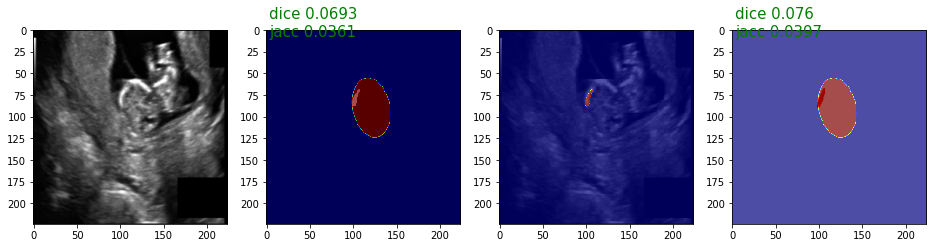

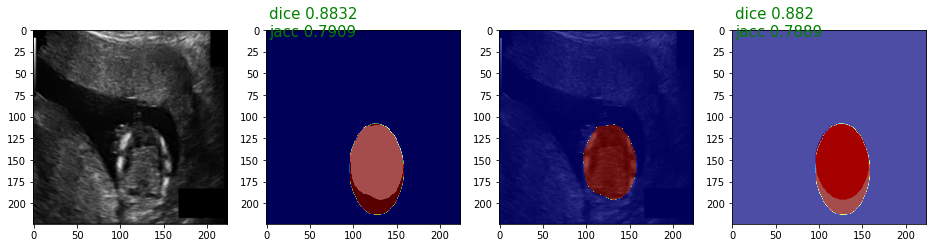

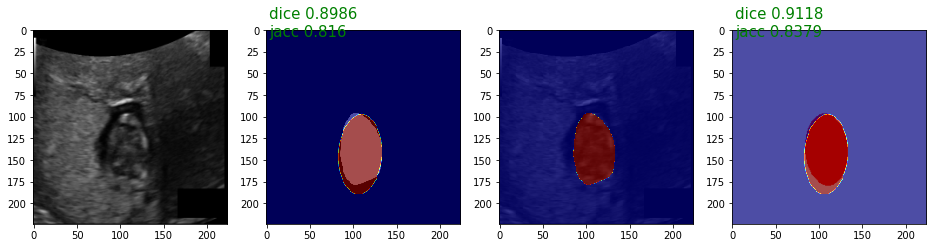

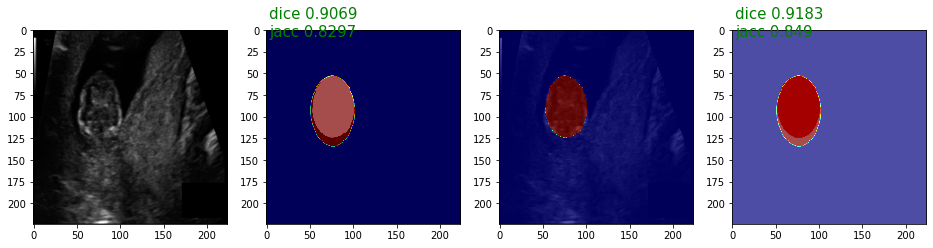

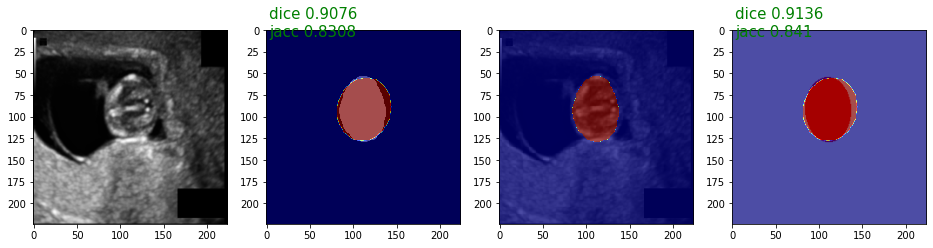

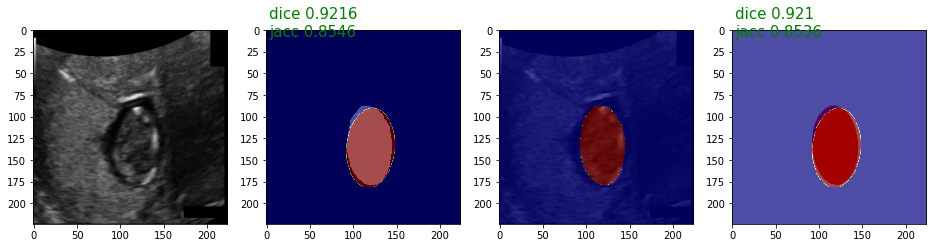

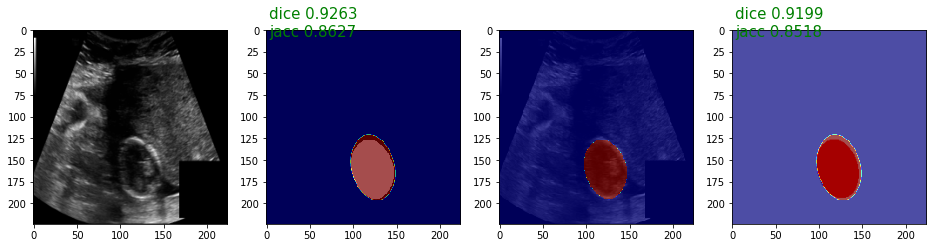

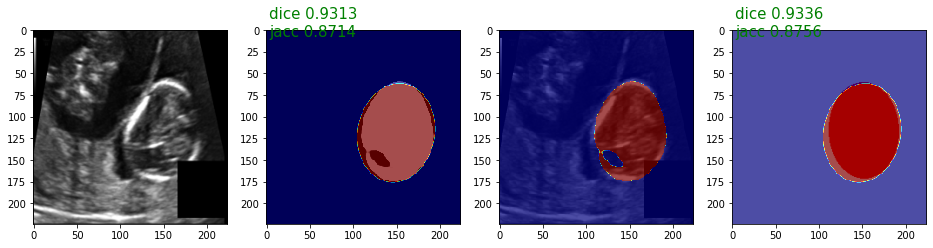

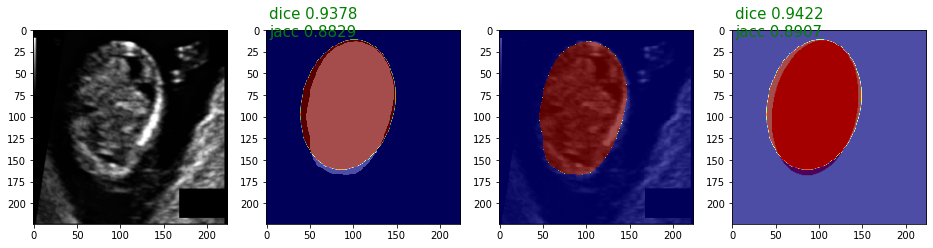

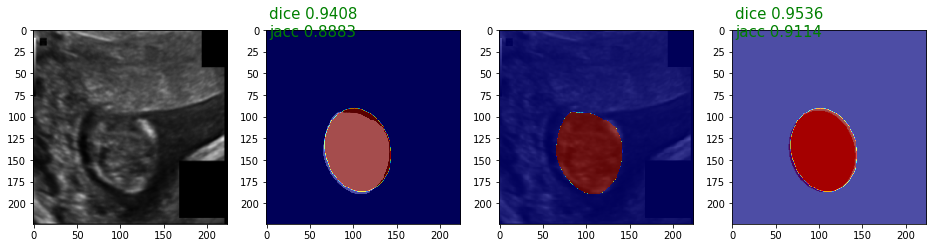

In [149]:

lowest_indices = np.argsort(dice_val)[0:10]
for i in lowest_indices:
  showImage(i,"AMS")

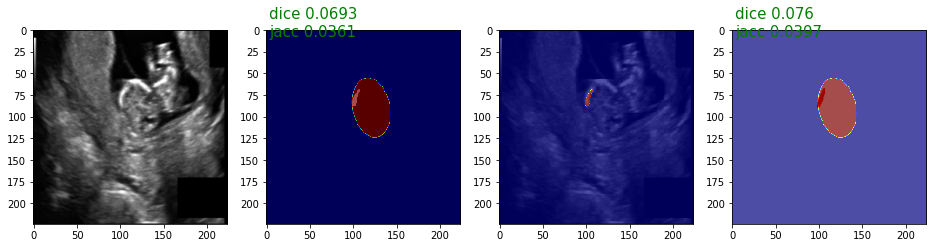

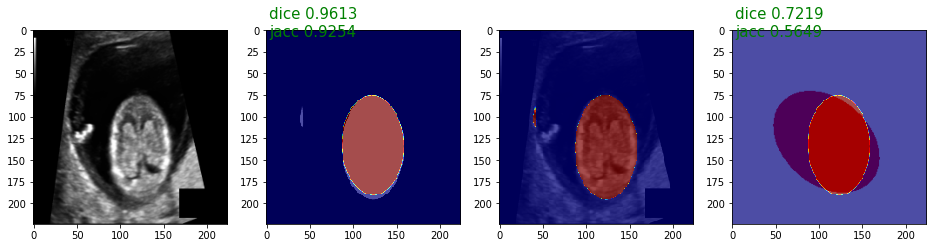

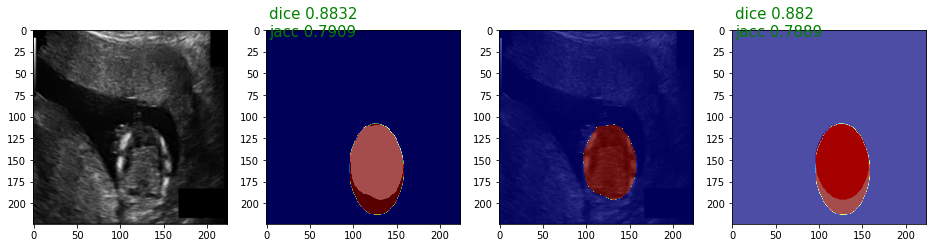

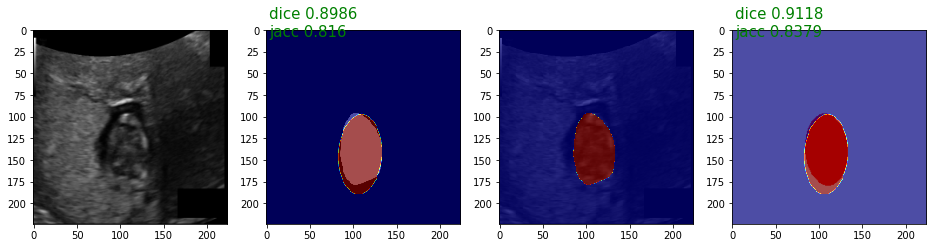

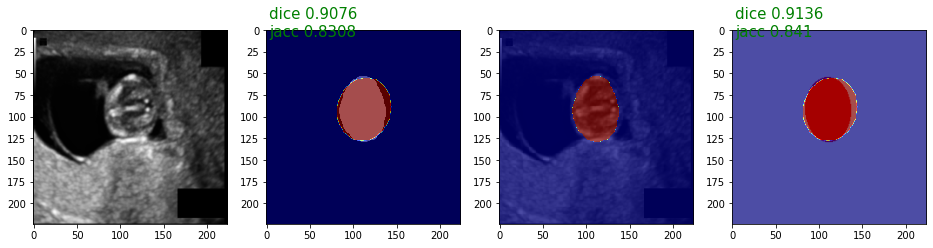

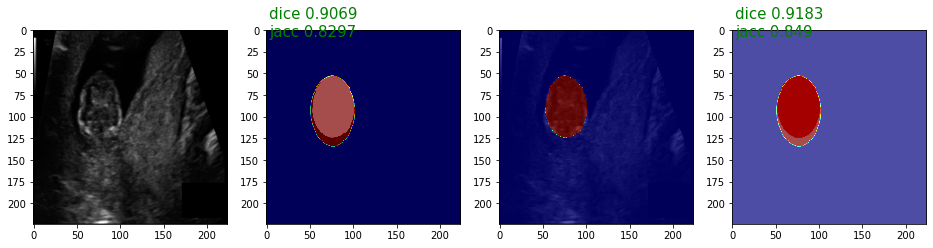

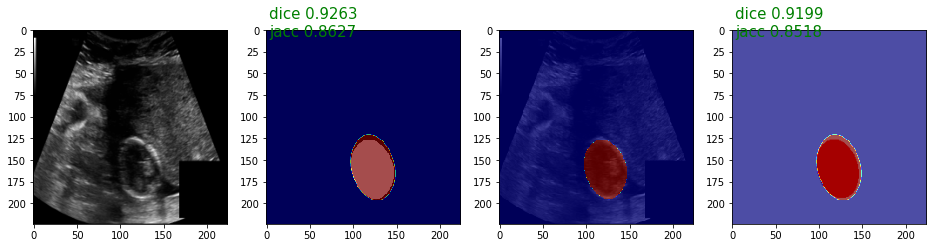

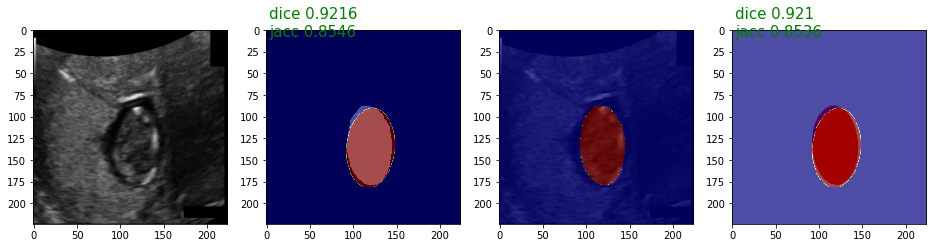

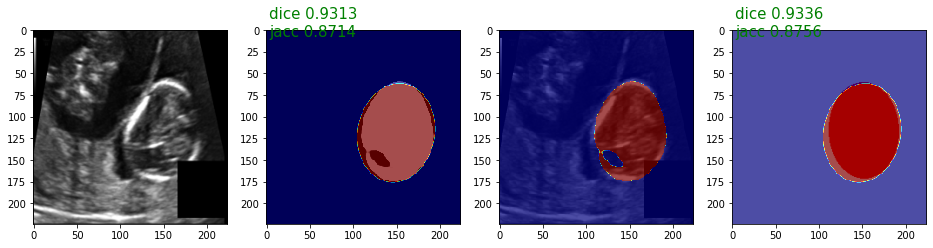

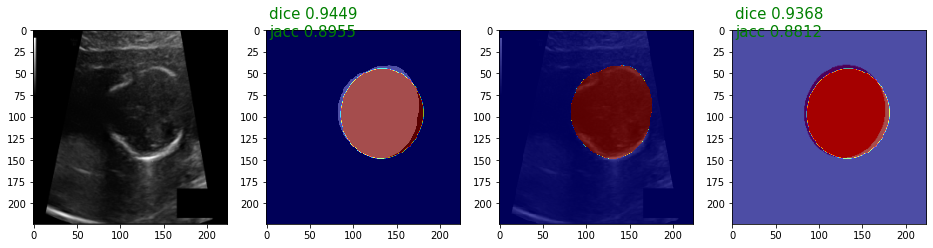

In [150]:
lowest_indices = np.argsort(ellipse_val_direct_dice)[0:10]
for i in lowest_indices:
  showImage(i,"AMS")

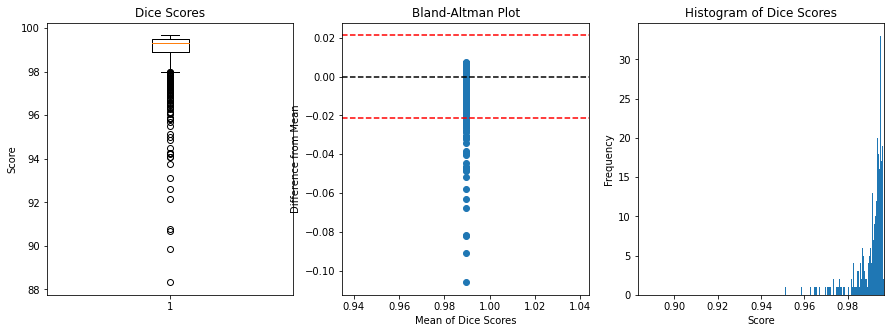

In [138]:

# Generate some random dice scores
dice_scores = np.array(dice_val)

#remove 1 outlier
dice_scores = dice_scores[dice_scores != np.min(dice_scores)]



# Create a boxplot of the dice scores
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].boxplot(dice_scores*100)
axs[0].set_title('Dice Scores')
axs[0].set_ylabel('Score')

# Create a Bland-Altman plot of the dice scores
mean = np.mean(dice_scores)
diff = dice_scores - mean
mean_diff = np.mean(diff)
std_diff = np.std(diff)
limit_of_agreement = 1.96 * std_diff
lower_loa = mean_diff - limit_of_agreement
upper_loa = mean_diff + limit_of_agreement
axs[1].scatter(np.full(len(diff), mean), diff)
axs[1].axhline(mean_diff, color='black', linestyle='--')
axs[1].axhline(lower_loa, color='red', linestyle='--')
axs[1].axhline(upper_loa, color='red', linestyle='--')
axs[1].set_title('Bland-Altman Plot')
axs[1].set_xlabel('Mean of Dice Scores')
axs[1].set_ylabel('Difference from Mean')

# Create a histogram of the dice scores
axs[2].hist(dice_scores, bins=1000)
axs[2].set_xlim([min(dice_scores), max(dice_scores)])
axs[2].set_title('Histogram of Dice Scores')
axs[2].set_xlabel('Score')
axs[2].set_ylabel('Frequency')



plt.show()


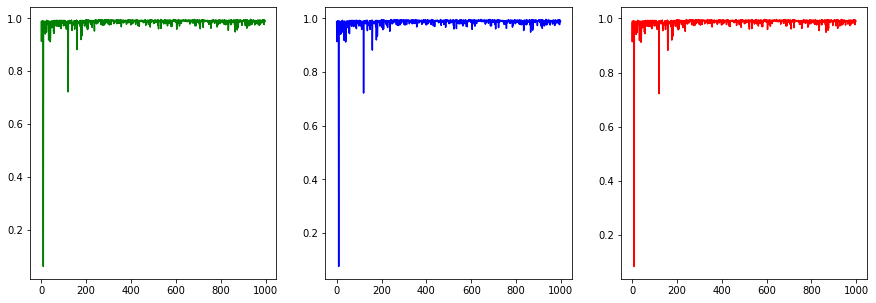

In [105]:

# Plot the data
fig, ax = plt.subplots(1,3,figsize=(15, 5))

ax[0].plot(ellipse_val_direct_dice, label='Direct method', color='green')
ax[1].plot(ellipse_val_AMS_dice, label='AMS method', color='blue')
ax[2].plot(ellipse_val_Simple_dice, label='Simple method', color='red')

# ax.set_xlabel('Sample Index')
# ax.set_ylabel('Dice Score')
# ax.set_title('Comparison of Ellipse Fitting Methods')

# ax.legend()
plt.show()

In [121]:
np.not_equal(ellipse_val_direct_dice, ellipse_val_AMS_dice).nonzero()



(array([9]),)

In [117]:
np.not_equal(ellipse_val_direct_dice, ellipse_val_Simple_dice).nonzero()


(array([9]),)

In [118]:
np.not_equal(ellipse_val_AMS_dice, ellipse_val_Simple_dice).nonzero()

(array([9]),)

In [122]:
print(ellipse_val_AMS_dice[9], ellipse_val_Simple_dice[9],ellipse_val_direct_dice[9])

tf.Tensor(0.07601536017206503, shape=(), dtype=float64) tf.Tensor(0.08430687178958027, shape=(), dtype=float64) tf.Tensor(0.06114984831641867, shape=(), dtype=float64)


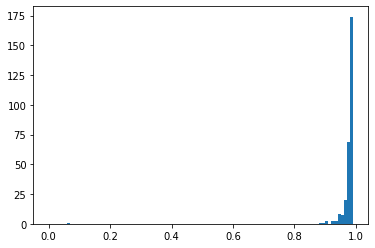

In [96]:

n, bins, patches = plt.hist(dice_val,bins=np.arange(0,1,0.01))
plt.show()


In [52]:
df_describe = pd.DataFrame(dice_val)
df_describe.describe()

,0
count,999.000000
mean,0.988448
std,0.031057
min,0.069280
25%,0.988917
50%,0.993120
75%,0.994868
max,0.996696


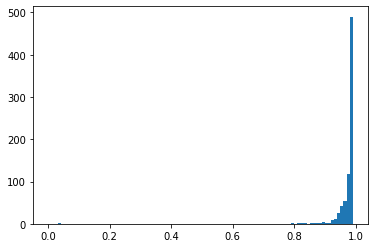

In [53]:
n, bins, patches = plt.hist(jac_val,bins=np.arange(0,1,0.01))
plt.show()

In [54]:
df_describe = pd.DataFrame(jac_val)
df_describe.describe()

,0
count,999.000000
mean,0.978236
std,0.036090
min,0.036089
25%,0.978079
50%,0.986334
75%,0.989788
max,0.993414


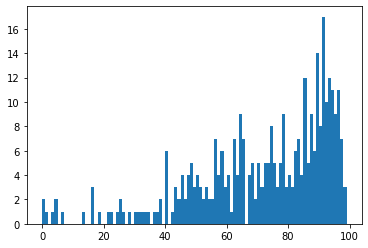

In [55]:
n, bins, patches = plt.hist(precision_val,bins=np.arange(0,100,1))
plt.show()

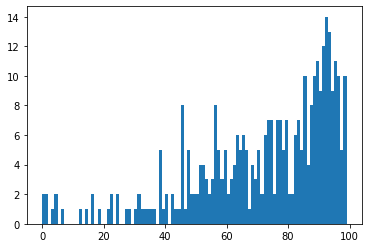

In [56]:

n, bins, patches = plt.hist(sensitivity_val,bins=np.arange(0,100,1))
plt.show()

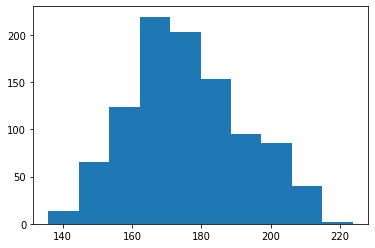

In [57]:

n, bins, patches = plt.hist(specificity_val)
plt.show()

bb